In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [6]:
df = pd.read_excel("../Data/Goals & Assist.xlsx")

print("Shape:", df.shape)
df.head()


Shape: (2274, 34)


,Unnamed: 0,Player,Nation,Position,Age,Matches Played,Starts,Minutes,90s Played,Goals,...,Goals Per 90,Assists Per 90,Goals + Assists Per 90,Non-Penalty Goals Per 90,Non-Penalty Goals + Assists Per 90,xG Per 90,xAG Per 90,xG + xAG Per 90,npxG Per 90,npxG + xAG Per 90
0,0,Mohamed Salah,EGY,AT,32,38,38,3371,37.5,29,...,0.77,0.48,1.25,0.53,1.01,0.67,0.38,1.05,0.49,0.87
1,1,Virgil van Dijk,NED,DF,33,37,37,3330,37.0,3,...,0.08,0.03,0.11,0.08,0.11,0.06,0.02,0.08,0.06,0.08
2,2,Ryan Gravenberch,NED,MT,22,37,37,3160,35.1,0,...,0.00,0.11,0.11,0.00,0.11,0.03,0.09,0.12,0.03,0.12
3,3,Alexis Mac Allister,ARG,MT,25,35,30,2599,28.9,5,...,0.17,0.17,0.35,0.17,0.35,0.10,0.16,0.26,0.10,0.26
4,4,Ibrahima Konaté,FRA,DF,25,31,30,2560,28.4,1,...,0.04,0.07,0.11,0.04,0.11,0.06,0.03,0.10,0.06,0.10


In [7]:
df_clean = df.copy()

drop_cols = [
    "Unnamed: 0",
    "Player", "Nation",
    "Goals + Assists",
    "Goals + Assists Per 90",
    "Non-Penalty Goals + Assists Per 90",
    "xG + xAG Per 90",
    "npxG + xAG Per 90",
]

drop_cols = [c for c in drop_cols if c in df_clean.columns]
df_clean = df_clean.drop(columns=drop_cols)

print("After drop:", df_clean.shape)
print(df_clean.dtypes)


After drop: (2274, 26)
Position                     object
Age                           int64
Matches Played                int64
Starts                        int64
Minutes                       int64
90s Played                  float64
Goals                         int64
Assists                       int64
Non-Penalty Goals             int64
Penalty Goals Made            int64
Penalty Attempts              int64
Yellow Cards                  int64
Red Cards                     int64
xG                          float64
npxG                        float64
xAG                         float64
npxG + xAG                  float64
Progressive Carries           int64
Progressive Passes            int64
Progressive Receives          int64
Goals Per 90                float64
Assists Per 90              float64
Non-Penalty Goals Per 90    float64
xG Per 90                   float64
xAG Per 90                  float64
npxG Per 90                 float64
dtype: object


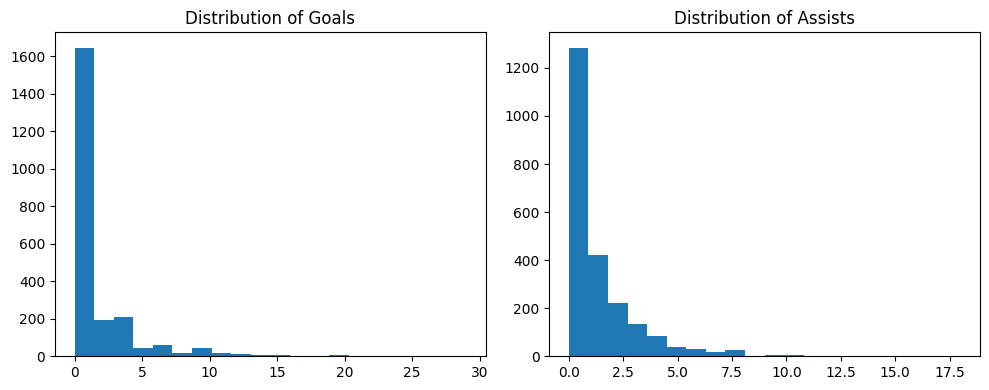

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

axes[0].hist(df_clean["Goals"], bins=20)
axes[0].set_title("Distribution of Goals")

axes[1].hist(df_clean["Assists"], bins=20)
axes[1].set_title("Distribution of Assists")

plt.tight_layout()
plt.show()


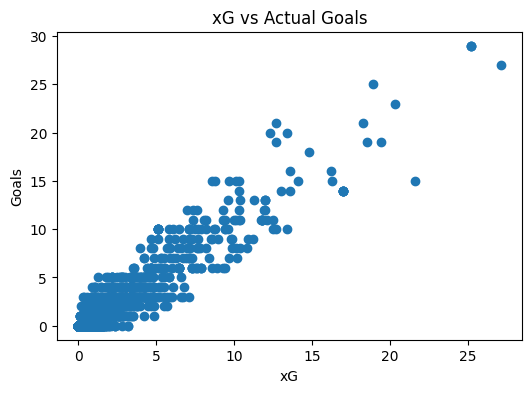

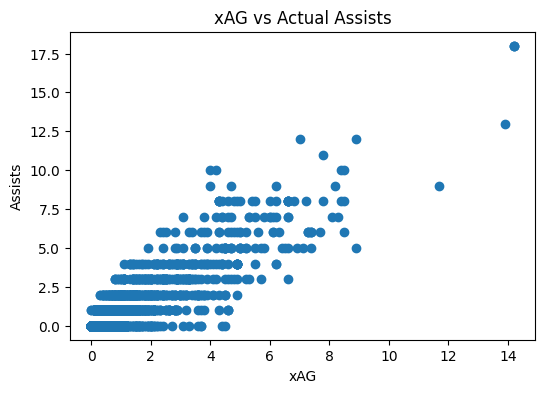

In [9]:
plt.figure(figsize=(6,4))
plt.scatter(df_clean["xG"], df_clean["Goals"])
plt.xlabel("xG")
plt.ylabel("Goals")
plt.title("xG vs Actual Goals")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(df_clean["xAG"], df_clean["Assists"])
plt.xlabel("xAG")
plt.ylabel("Assists")
plt.title("xAG vs Actual Assists")
plt.show()


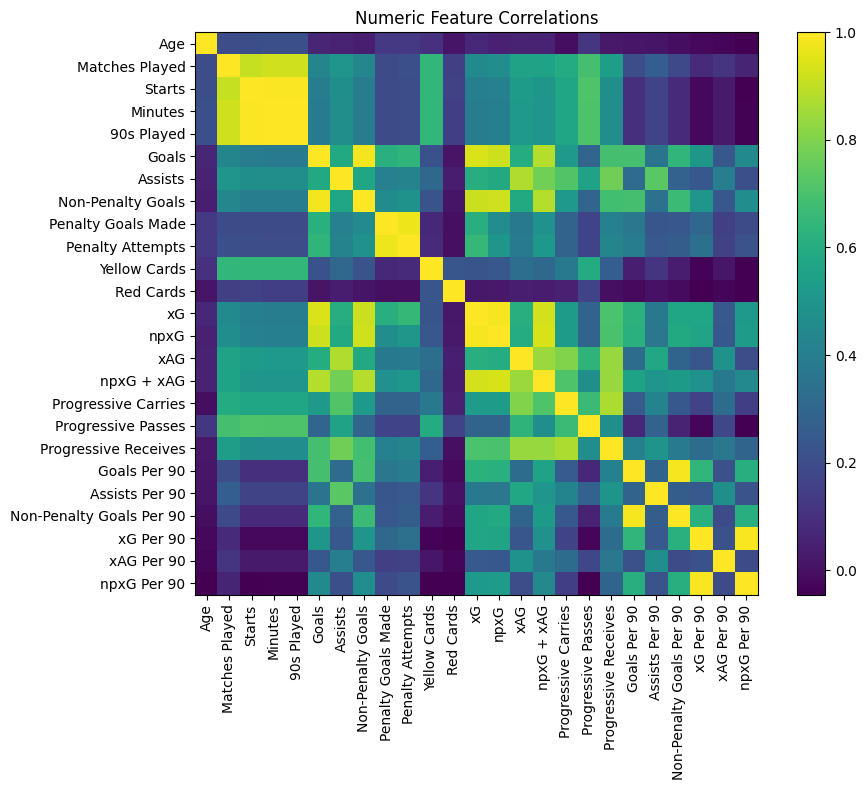

In [10]:
numeric_cols = df_clean.select_dtypes(include="number").columns.tolist()
corr = df_clean[numeric_cols].corr()

plt.figure(figsize=(10,8))
plt.imshow(corr, interpolation="nearest")
plt.title("Numeric Feature Correlations")
plt.colorbar()
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.tight_layout()
plt.show()


In [11]:
targets = ["Goals", "Assists"]
categorical_features = ["Position"]

all_numeric = df_clean.select_dtypes(include="number").columns.tolist()

leak_like_cols = [
    "Goals", "Assists",
    "Goals Per 90",
    "Assists Per 90",
    "Goals + Assists Per 90",
    "Non-Penalty Goals Per 90",
    "Non-Penalty Goals + Assists Per 90",
    "Non-Penalty Goals"
]

numeric_features = [c for c in all_numeric if c not in leak_like_cols]

print("Categorical:", categorical_features)
print("Numeric:", numeric_features)


Categorical: ['Position']
Numeric: ['Age', 'Matches Played', 'Starts', 'Minutes', '90s Played', 'Penalty Goals Made', 'Penalty Attempts', 'Yellow Cards', 'Red Cards', 'xG', 'npxG', 'xAG', 'npxG + xAG', 'Progressive Carries', 'Progressive Passes', 'Progressive Receives', 'xG Per 90', 'xAG Per 90', 'npxG Per 90']


In [12]:
from sklearn.pipeline import Pipeline

num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, numeric_features),
        ("cat", cat_transformer, categorical_features),
    ],
    remainder="drop"
)


In [13]:
def evaluate_regression_model(model, X, y, model_name="Model", cv_splits=5):
    """
    Returns: dict of CV RMSE, CV R2, and prints them in a simple way.
    """
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE)
    
    rmse_scores = []
    r2_scores = []
    
    for train_idx, test_idx in kf.split(X):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)
        
        mse = mean_squared_error(y_te, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_te, y_pred)
        
        rmse_scores.append(rmse)
        r2_scores.append(r2)
    
    print(f"\n{model_name} - CV Results:")
    print(f"  RMSE: {np.mean(rmse_scores):.3f} ± {np.std(rmse_scores):.3f}")
    print(f"  R²:   {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")
    
    return {
        "cv_rmse_mean": np.mean(rmse_scores),
        "cv_rmse_std": np.std(rmse_scores),
        "cv_r2_mean": np.mean(r2_scores),
        "cv_r2_std": np.std(r2_scores)
    }


In [14]:
results_summary = {}

for target in targets:
    print("\n" + "="*60)
    print(f"TARGET: {target}")
    print("="*60)
    
    # 1. Prepare X, y
    df_target = df_clean.dropna(subset=[target]).copy()
    X = df_target[categorical_features + numeric_features]
    y = df_target[target].astype(float)
    
    # 2. Train/test split (for a final hold-out evaluation)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=RANDOM_STATE
    )
    
    # 3. Define models
    ridge_model = Pipeline([
        ("pre", preprocessor),
        ("reg", Ridge(alpha=1.0))
    ])
    
    rf_model = Pipeline([
        ("pre", preprocessor),
        ("reg", RandomForestRegressor(
            n_estimators=300,
            max_depth=None,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ])
    
    # 4. Cross-validation on TRAIN data
    ridge_cv = evaluate_regression_model(ridge_model, X_train, y_train, model_name="Ridge")
    rf_cv = evaluate_regression_model(rf_model, X_train, y_train, model_name="RandomForest")
    
    # 5. Final fit on full train + test evaluation
    ridge_model.fit(X_train, y_train)
    y_pred_ridge = ridge_model.predict(X_test)
    
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    
    def eval_on_test(name, y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        print(f"\n{name} - TEST SET:")
        print(f"  MAE:  {mae:.3f}")
        print(f"  RMSE: {rmse:.3f}")
        print(f"  R²:   {r2:.3f}")
        return {"mae": mae, "rmse": rmse, "r2": r2}
    
    ridge_test = eval_on_test("Ridge", y_test, y_pred_ridge)
    rf_test = eval_on_test("RandomForest", y_test, y_pred_rf)
    
    # 6. Store results
    results_summary[target] = {
        "ridge_cv": ridge_cv,
        "ridge_test": ridge_test,
        "rf_cv": rf_cv,
        "rf_test": rf_test
    }



TARGET: Goals

Ridge - CV Results:
  RMSE: 1.028 ± 0.031
  R²:   0.893 ± 0.012

RandomForest - CV Results:
  RMSE: 1.036 ± 0.124
  R²:   0.892 ± 0.010

Ridge - TEST SET:
  MAE:  0.668
  RMSE: 1.097
  R²:   0.859

RandomForest - TEST SET:
  MAE:  0.620
  RMSE: 1.142
  R²:   0.848

TARGET: Assists

Ridge - CV Results:
  RMSE: 0.883 ± 0.061
  R²:   0.773 ± 0.038

RandomForest - CV Results:
  RMSE: 0.886 ± 0.072
  R²:   0.773 ± 0.026

Ridge - TEST SET:
  MAE:  0.572
  RMSE: 0.927
  R²:   0.733

RandomForest - TEST SET:
  MAE:  0.535
  RMSE: 0.953
  R²:   0.717


In [15]:
print("\n" + "="*60)
print("FINAL SUMMARY: GOALS & ASSISTS MODELS")
print("="*60)

for target in targets:
    print(f"\nTarget: {target}")
    r = results_summary[target]
    print("  Ridge    - Test RMSE: {:.3f}, R²: {:.3f}".format(
        r["ridge_test"]["rmse"], r["ridge_test"]["r2"]
    ))
    print("  RandomRF - Test RMSE: {:.3f}, R²: {:.3f}".format(
        r["rf_test"]["rmse"], r["rf_test"]["r2"]
    ))



FINAL SUMMARY: GOALS & ASSISTS MODELS

Target: Goals
  Ridge    - Test RMSE: 1.097, R²: 0.859
  RandomRF - Test RMSE: 1.142, R²: 0.848

Target: Assists
  Ridge    - Test RMSE: 0.927, R²: 0.733
  RandomRF - Test RMSE: 0.953, R²: 0.717
